In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import truncnorm, norm

np.seterr(all="raise", under="warn")

# Priority Queue
import heapq as hq

from tqdm import tqdm_notebook as tqdm

from sobol_seq import i4_sobol_generate

from sampling import normal_normal_log_diff, normal_normal_region_bound
from sampling import gumbel_pdf, gumbel_cdf, gumbel_inv_cdf, gumbel_sample
from sampling import trunc_gumbel_pdf, trunc_gumbel_cdf, trunc_gumbel_inv_cdf, trunc_gumbel_sample

In [2]:
np.random.seed(42)

P_unnorm = np.random.uniform(size=20)
P = P_unnorm / np.sum(P_unnorm)

# Gumbel - Max Trick

In [3]:
num_samples = 10000

max_samples = []
argmax_samples = [0] * len(P)

# Get the log-unnormalized probability
phi = np.log(P_unnorm)

for i in tqdm(range(num_samples)):
    # Sample a Gumbel:
    # 1. Sample U ~ Uniform(0, 1)
    # 2. Apply inverse CDF of Gumbel: G = -log(-log(U))
    u = np.random.uniform(size=len(P))
    g = -np.log(-np.log(u))

    # Add the Gumbel noise
    z = phi + g

    # Get the max and argmax
    m = np.max(z)
    k = np.argmax(z)

    max_samples.append(m)
    argmax_samples[k] += 1

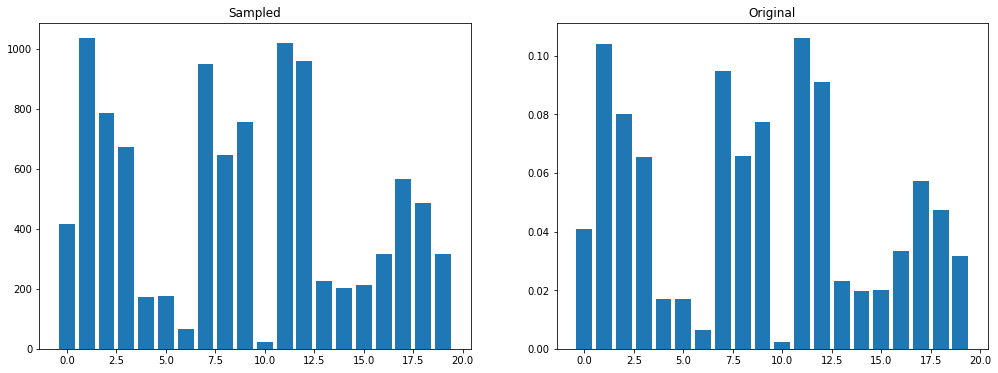

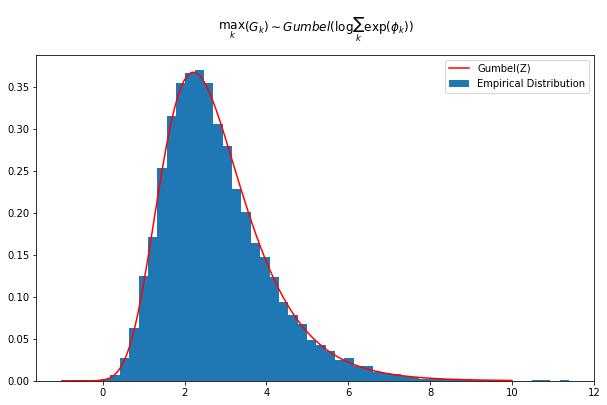

In [4]:
plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.bar(np.arange(len(P)), argmax_samples)
plt.title("Sampled")

plt.subplot(122)
plt.bar(np.arange(20), P)
plt.title("Original")
plt.show()

# calculate log partition function
log_partition = logsumexp(phi)

xs = np.linspace(-1, 10, 200)

plt.figure(figsize=(10, 6))
plt.plot(xs, gumbel_pdf(xs, log_partition), color='r', label='Gumbel(Z)')
plt.hist(max_samples, bins=50, density=True, label='Empirical Distribution')
plt.title("$\max_{k}(G_k) \sim Gumbel(\log\sum_k\exp(\phi_k))$\n")
plt.legend()
plt.show()

# Coded Gumbel-Max Sampling

In [36]:
num_samples = 10000

prop_samples = [0] * len(P)
post_samples = [0] * len(P)

# lol
post_codes = []

# Get the log-unnormalized probability of target
log_target = np.log(P_unnorm)
log_prop = np.zeros_like(log_target)

log_diff = log_target - log_prop

post_samp_seq = []

# Encoding part
for i in tqdm(range(num_samples)):
    
    np.random.seed(i)
    
    # Sample a Gumbel:
    # 1. Sample U ~ Uniform(0, 1)
    # 2. Apply inverse CDF of Gumbel: G = -log(-log(U))
    u = np.random.uniform(size=len(P))
    g = -np.log(-np.log(u))

    # Add the Gumbel noise to the proposal
    z = log_prop + g

    # Get the max and argmax
    k = np.argmax(z)
    
    prop_samples[k] += 1
    
    # Now sample the posterior by adding the log difference and taking its argmax
    z_ = z + log_diff
    
    k_ = np.argmax(z_)

    post_samples[k_] += 1
    
    post_codes.append(k_ - k)
    
    post_samp_seq.append(k_)
    
    
decoded_post_samples = [0] * len(P)
decoded_post_samp_seq = []
    
# Decoding part. No access to posterior
for i in tqdm(range(num_samples)):
    
    np.random.seed(i)
    
    # Sample a Gumbel:
    # 1. Sample U ~ Uniform(0, 1)
    # 2. Apply inverse CDF of Gumbel: G = -log(-log(U))
    u = np.random.uniform(size=len(P))
    g = -np.log(-np.log(u))

    # Add the Gumbel noise to the proposal
    z = log_prop + g

    # Get back the sample
    k = np.argmax(z)
    
    # Now get back the posterior sample by adding the index difference
    k_ = k + post_codes[i]
    
    decoded_post_samples[k_] += 1
    
    decoded_post_samp_seq.append(k_)
    
print(np.all(np.array(decoded_post_samp_seq) == np.array(post_samp_seq)))


True


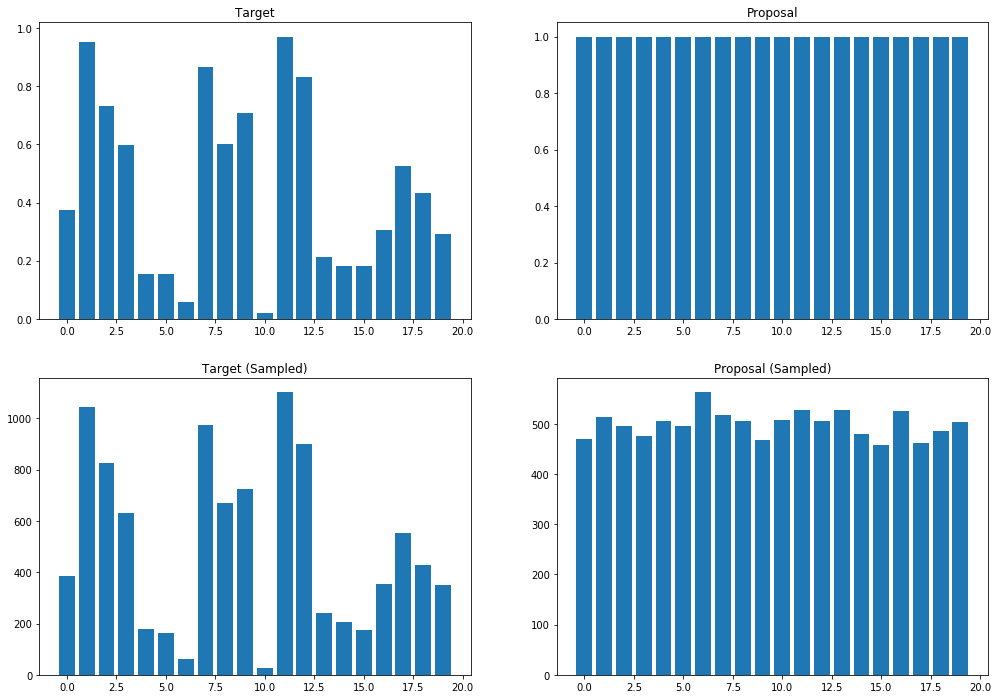

In [33]:
plt.figure(figsize=(17, 12))
plt.subplot(221)
plt.bar(np.arange(20), np.exp(log_target))
plt.title("Target")

plt.subplot(222)
plt.bar(np.arange(20), np.exp(log_prop))
plt.title("Proposal")

plt.subplot(223)
plt.bar(np.arange(20), post_samples)
plt.title("Target (Sampled)")

plt.subplot(224)
plt.bar(np.arange(20), prop_samples)
plt.title("Proposal (Sampled)")

plt.show()

# Coded Gumbel-Max Sampling on Gaussians

# A* sampling

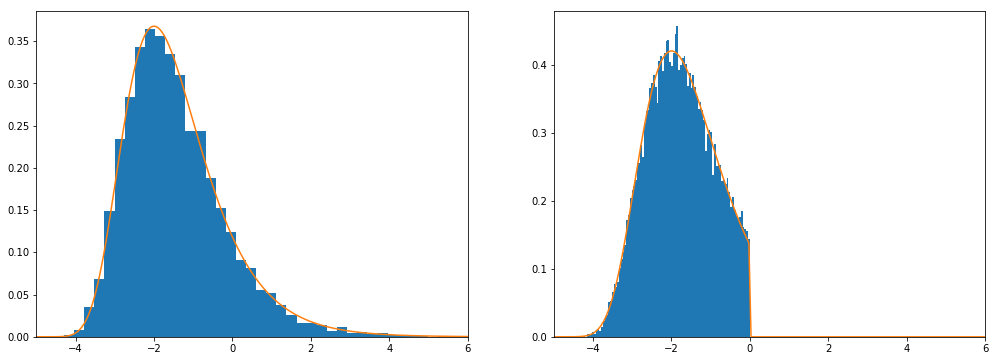

In [5]:
xs = np.linspace(-5, 6, 200)

plt.figure(figsize=(17,6))
plt.subplot(121)
plt.hist(gumbel_sample(size=10000, loc=-2.), bins=50, density=True)
plt.plot(xs, gumbel_pdf(xs, loc=-2.))
plt.xlim([-5, 6])

plt.subplot(122)
plt.hist(trunc_gumbel_sample(trunc=0., loc=-2., size=30000), bins=100, density=True)
plt.plot(xs, trunc_gumbel_pdf(xs, trunc=0., loc=-2.))
plt.xlim([-5, 6])
plt.show()

In [6]:
# =================================================================================
# A* sampling
# =================================================================================

def a_star_sample(prop_trunc_samp, prop_log_mass, log_diff, region_bound, seed, code_path=None, verbose=False):
    """
    prop_log_mass - function taking 2 arguments a, b and calculates \log\int_a^b i(x) dx
    
    prop_trunc_samp - function taking 2 arguments a, b and samples from the truncated Gibbs
                      distribuiton of i(x), i.e. it samples X ~ exp(i(x))/Z where
                      x \in [a, b] and Z = \int_a^b exp(i(x)) dx
                      
    log_diff - function taking 1 argument, is o(x) in the paper
    
    region_bound - function taking 2 arguments a, b; is M(B) in the paper
    """
    
    np.random.seed(seed)
    
    def plot_samp(x, g, diff):
        plt.plot([x, x], [diff, diff + g], color='b')
        plt.scatter([x], [diff + g], color='b')
    
    # Initialisation
    lower_bound = -np.inf
    samp = None
    k = 0
    
    queue = []
    
    samp_idx = 0
    
    G = []
    X = []
    B = []
    M = []
    
    # First split:
    # generate maximum and maximum location
    b_1 = (-np.inf, np.inf)
    
    g_1 = gumbel_sample(loc=prop_log_mass(*b_1))
    x_1 = prop_trunc_samp(*b_1)
    
    m_1 = region_bound(*b_1)
    
    # If we are decoding and no directions are provided,
    # it means we should return the root node
    if code_path is not None and len(code_path) == 0:
        return x_1
    
    # Store G_1, X_1, B_1, M_1
    G.append(g_1)
    X.append(x_1)
    B.append(b_1)
    M.append(m_1)
    
    if verbose:
        plot_samp(x_1, g_1, log_diff(x_1))
    
    # The heapq implementation of the heap is a min heap not a max heap!
    hq.heappush(queue, (-(g_1 + m_1), 0, ""))
    
    # Run A* search
    # Note: since we are using the negative of the upper bounds
    # we have to negate it again at this check
    while len(queue) > 0 and lower_bound < -min(queue)[0]:
        
        # Get the bound with the highest priority
        _, p, path = hq.heappop(queue)
        
        # Calculate new proposed lower bound based on G_p
        lower_bound_p = G[p] + log_diff(X[p])
        
        # Check if the lower bound can be raised
        if lower_bound < lower_bound_p:
            
            lower_bound = lower_bound_p
            samp = X[p]
            samp_idx = p
            samp_path = path
            
        # Partition the space: split the current interval by X_p
        L = (B[p][0], X[p])
        R = (X[p], B[p][1])
        
        # Go down the heap / partitions
        for C, direction in zip([L, R], ['0', '1']):
            
            # TODO: check if this is a sufficiently good empty set condition
            if not C[0] == C[1]:  
                
                k += 1
                
                b_k = C
                g_k = trunc_gumbel_sample(loc=prop_log_mass(*C),
                                          trunc=G[p])
                x_k = prop_trunc_samp(*C)
                
                # If the path to the sample matches, then we are done and the
                # current sample is the one we wanted
                if code_path is not None and code_path == path + direction:
                    return x_k
                
                # Store B_k, G_k, X_k
                B.append(b_k)
                G.append(g_k)
                X.append(x_k)
                
                if verbose:
                    plot_samp(x_k, g_k, log_diff(x_k))
                
                # Check if there is a point in continuing the search along this path
                if lower_bound < g_k + M[p]:
                    m_k = region_bound(*b_k)
                    M.append(m_k)
                    
                    if lower_bound < g_k + m_k:
                        
                        hq.heappush(queue, (-(g_k + m_k), k, path + direction))
                else:
                    # We push a non-informative bound here, so that the length of M 
                    # is the same as the rest
                    M.append(0)
                    
    return lower_bound, samp, samp_idx, samp_path

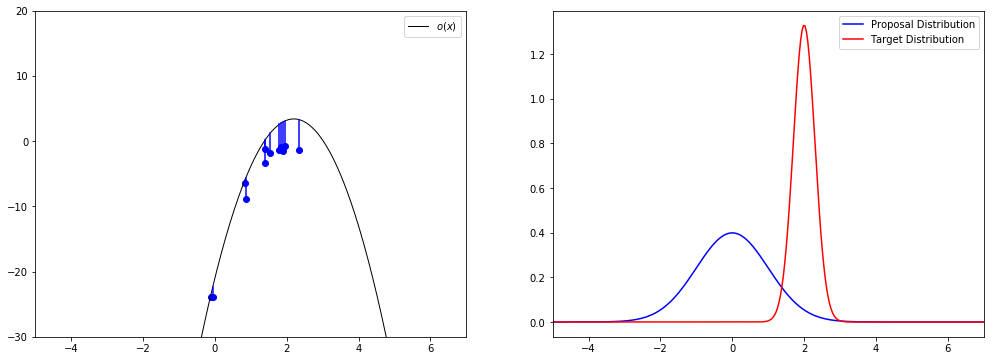

(-0.7292834918057669, 1.9508453394258733, 10, '11111')
1.9508453394258733


In [7]:
mu_prop = 0.
sigma_prop = 1.

mu_target = 2
sigma_target = 0.3


xs = np.linspace(-5, 7, 300)

log_diff = lambda x: normal_normal_log_diff(x, mu_prop, sigma_prop, mu_target, sigma_target)

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.plot(xs, log_diff(xs), color='k', label="$o(x)$", linewidth=1)

res = a_star_sample(prop_trunc_samp=lambda a, b: truncnorm.ppf(np.random.uniform(), a, b), 
                    prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                    log_diff=log_diff, 
                    region_bound=lambda a, b: normal_normal_region_bound(a, 
                                                                         b, 
                                                                         mu_prop, 
                                                                         sigma_prop, 
                                                                         mu_target, 
                                                                         sigma_target),
                    seed=420,
                    verbose=True)

plt.legend()
plt.ylim([-30, 20])
plt.xlim([-5, 7])

plt.subplot(122)
plt.plot(xs, norm.pdf(xs, mu_prop, sigma_prop), color='b', label="Proposal Distribution")
plt.plot(xs, norm.pdf(xs, mu_target, sigma_target), color='r', label="Target Distribution")
plt.legend()
plt.xlim([-5, 7])

plt.show()

decode_res = a_star_sample(prop_trunc_samp=lambda a, b: truncnorm.ppf(np.random.uniform(), a, b), 
                    prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                    log_diff=log_diff, 
                    region_bound=lambda a, b: normal_normal_region_bound(a, 
                                                                         b, 
                                                                         mu_prop, 
                                                                         sigma_prop, 
                                                                         mu_target, 
                                                                         sigma_target),
                    seed=420,
                    code_path=res[3],
                    verbose=False)

print(res)
print(decode_res)

In [8]:
# for reproducibility
np.random.seed(4)

samples = []
samp_paths = []
num_samples = 10000

indexed_samples = {}

for i in tqdm(range(num_samples)):
    _, samp, samp_idx, samp_path = a_star_sample(prop_trunc_samp=lambda a, b: truncnorm.ppf(np.random.uniform(), a, b), 
                            prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                            log_diff=lambda x: normal_normal_log_diff(x, mu_prop, sigma_prop, mu_target, sigma_target), 
                            region_bound=lambda a, b: normal_normal_region_bound(a, b, mu_prop, sigma_prop, mu_target, sigma_target),
                            seed=i,
                            verbose=False)
    
    if samp_idx in indexed_samples:
        indexed_samples[samp_idx].append(samp)
    else:
        indexed_samples[samp_idx] = [samp]
    
    samples.append(samp)
    samp_paths.append(samp_path)
    
samples = np.array(samples)

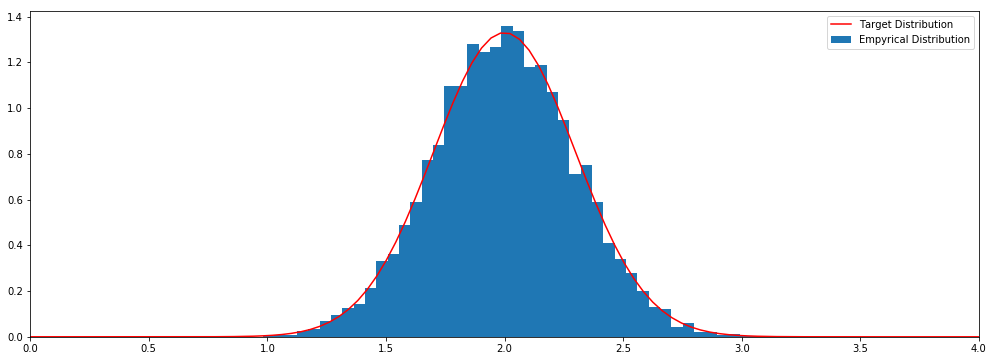

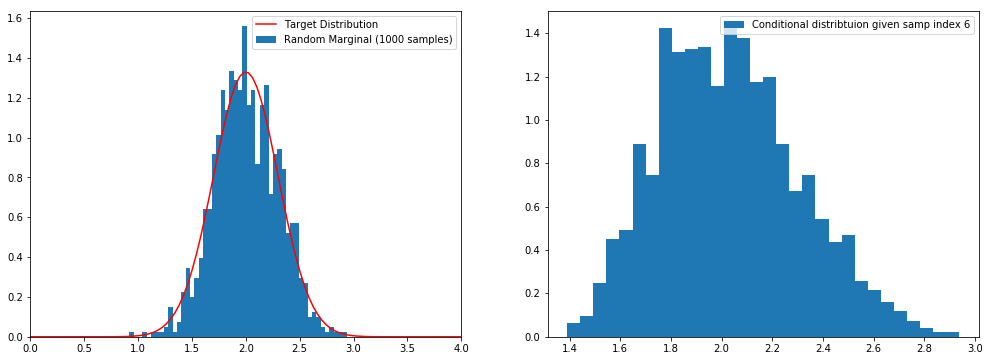

In [9]:
plt.figure(figsize=(17, 6))
plt.hist(samples, bins=50, density=True, label="Empyrical Distribution")
plt.plot(xs, norm.pdf(xs, mu_target, sigma_target), color='r', label="Target Distribution")
plt.xlim([mu_target - 2, mu_target + 2])
plt.legend()
plt.show()

marginal_size = 1000

plt.figure(figsize=(17, 6))
plt.subplot(121)

plt.hist(samples[np.random.choice(len(samples), size=marginal_size, replace=False)], 
         bins=50, 
         density=True,
         label="Random Marginal ({} samples)".format(marginal_size))

plt.plot(xs, norm.pdf(xs, mu_target, sigma_target), label="Target Distribution", color='r')
plt.xlim([mu_target - 2, mu_target + 2])
plt.legend()

idx = 6

plt.subplot(122)
plt.hist(indexed_samples[idx], 
         bins=30, 
         density=True, 
         label="Conditional distribtuion given samp index {}".format(idx))
plt.legend()
plt.show()

In [10]:
decoded_samples = []
num_samples = 10000


for i in tqdm(range(num_samples)):
    samp = a_star_sample(prop_trunc_samp=lambda a, b: truncnorm.ppf(np.random.uniform(), a, b), 
                            prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                            log_diff=lambda x: normal_normal_log_diff(x, mu_prop, sigma_prop, mu_target, sigma_target), 
                            region_bound=lambda a, b: normal_normal_region_bound(a, b, mu_prop, sigma_prop, mu_target, sigma_target),
                            seed=i,
                            code_path=samp_paths[i],
                            verbose=False)
    
    decoded_samples.append(samp)
    
decoded_samples = np.array(samples)

# Check if the two arrays are the same
np.sum(np.abs(samples - decoded_samples))

0.0

# Coding without the log difference function

In [5]:
class TreeLeaf:
        def __init__(self, val, idx):
            # Sample value
            self.val = val
            
            # Sample index
            self.idx = idx
            
            # Children
            self.left = None
            self.right = None
            
        def __str__(self):
            return "{} : {}".format(self.val, self.idx)

class IntervalTree:
        
    def __init__(self):
        self.root = None
        self.idx = 0
        
        self.node_list = []
        
        
    def add(self, val):
        
        leaf = TreeLeaf(val, self.idx)
         
        if self.root is None:
            self.root = leaf
        else:
            current = self.root
            
            while True:
                
                if val < current.val:
                    
                    if current.left is None:
                        current.left = leaf
                        break
                    else:
                        current = current.left
                    
                elif val > current.val:
                    
                    if current.right is None:
                        current.right = leaf
                        break
                    else:
                            
                        current = current.right
                        
        self.idx += 1
        self.node_list.append(leaf)
       
    
    def _to_list(self, node):
        if node is not None:
            
            l = self._to_list(node.left)
            
            l += [(node.val, node.idx)]
            
            l += self._to_list(node.right)
            
            return l
        else:
            return []
        
    def to_list(self):
        if self.root is None:
            raise Exception("No entries in tree!")
            
        return self._to_list(self.root)
    
                        
    def between(self, low, high):
        """
        This is just the lowest common ancestor algorithm
        """
        
        if self.root is None:
            raise Exception("No entries in tree!")
            
        if low >= high:
            raise Exception("Low must be less than high!")
        
        current = self.root
        
        while current is not None:
            
            if current.val < low and current.val < high:
                current = current.right
                
            elif current.val > low and current.val > high:
                current = current.left
                
            else:
                if current.val == low:
                    current = current.right
                    
                    while current is not None:
                        if current.val < high:
                            break
                        else:
                            should_break = current.val == high
                            
                            current = current.left
                            
                            if should_break: break
                
                elif current.val == high:
                    current = current.left
                    
                    while current is not None:
                        if current.val > low:
                            break
                        else:
                            should_break = current.val == low
                            
                            current = current.right
                            
                            if should_break: break
                        
                    
                return None if current is None else (current.val, current.idx)
            
        return None
    
                
    def _pretty_print(self, node, indent):
        
        if node is not None:
            
            self._pretty_print(node.left, indent + 2)
            
            print("  " * indent + " " + str(node),)
            
            self._pretty_print(node.right, indent + 2)
            
        
    def pretty_print(self):
        self._pretty_print(self.root, 0)

In [6]:
# =================================================================================
# A* sampling
# =================================================================================

def a_star_sample_(prop_samp, 
                   prop_log_mass, 
                   log_diff, 
                   samp_tree, 
                   seed, 
                   samp_list,
                   region_bound, 
                   verbose=False, 
                   eps=1e-4):
    """
    prop_log_mass - function taking 2 arguments a, b and calculates \log\int_a^b i(x) dx
    
    prop_trunc_samp - function taking 2 arguments a, b and samples from the truncated Gibbs
                      distribuiton of i(x), i.e. it samples X ~ exp(i(x))/Z where
                      x \in [a, b] and Z = \int_a^b exp(i(x)) dx
                      
    log_diff - function taking 1 argument, is o(x) in the paper
    
    region_bound - function taking 2 arguments a, b; is M(B) in the paper
    """
    
    num_samples_pow = 15

    normal_approx_samp_block = np.random.normal(size=(2**num_samples_pow, 1))

    normal_tree = IntervalTree()

    for i in range(2**num_samples_pow):
        normal_tree.add(normal_approx_samp_block[i, 0])
    
    def plot_samp(x, g, diff, color='b'):
        plt.plot([x, x], [diff, diff + g], color=color)
        plt.scatter([x], [diff + g], color=color)
    
    if seed is not None:
        np.random.seed(seed)
    
    # Initialisation
    lower_bound = -np.inf
    samp = None
    k = 0
    
    queue = []
    
    samp_bounds = None
    
    G = []
    X = []
    B = []
    M = []
    
    # First split:
    # generate maximum and maximum location
    b_1 = (-np.inf, np.inf)
    
    g_1 = gumbel_sample(loc=prop_log_mass(*b_1))
    
    if seed is not None:
        x_1, idx = bounded_rejection_sample(sampling_fn=prop_samp,
                                            low=b_1[0],
                                            high=b_1[1],
                                            seed=seed)
    elif samp_list is not None:
        x_1, idx = bounded_rejection_sample_with_list(samp_list, b_1[0], b_1[1])
    else:
        x_1, idx = normal_tree.between(low=b_1[0],
                                       high=b_1[1])
        
    m_1 = region_bound(*b_1)
    
    # Store G_1, X_1, B_1, M_1
    G.append(g_1)
    X.append(x_1)
    B.append(b_1)
    M.append(m_1)
    
    if verbose:
        print(g_1, b_1, x_1)
        plot_samp(x_1, g_1, log_diff(x_1))
    
    # The heapq implementation of the heap is a min heap not a max heap!
    hq.heappush(queue, (-(g_1 + m_1), 0, idx))
    
    # Run A* search
    # Note: since we are using the negative of the upper bounds
    # we have to negate it again at this check
    while len(queue) > 0 and lower_bound < -min(queue)[0]:
        
        # Get the bound with the highest priority
        _, p, p_idx = hq.heappop(queue)
        
#         cdf_lb = norm.cdf(B[p][0])
#         cdf_ub = norm.cdf(B[p][1])
#         midpoint = (cdf_lb + cdf_ub) / 2
#         midpoint = norm.ppf(midpoint)
        
        # Calculate new proposed lower bound based on G_p
        lower_bound_p = G[p] + log_diff(X[p])
        
        # Check if the lower bound can be raised
        if lower_bound < lower_bound_p:
            
#             lower_bound = lower_bound_p
#             samp = X[p]
#             samp_idx = p
#             samp_path = path
#             samp_bounds = b_p

            lower_bound = lower_bound_p

            idx = p_idx
            samp = X[p] 
            
        # Partition the space: split the current interval by X_p
        L = (B[p][0], X[p])
        R = (X[p], B[p][1])

#         L = (B[p][0], midpoint)
#         R = (midpoint, B[p][1])
        
        # Go down the heap / partitions
        for C, direction in zip([L, R], ['0', '1']):
            
            # TODO: check if this is a sufficiently good empty set condition
            if not np.abs(C[0] - C[1]) < eps:  
                
                k += 1
                
                b_k = C
                
                g_k = trunc_gumbel_sample(loc=prop_log_mass(*C),
                                          trunc=G[p])

                if seed is not None:
                    x_k, k_idx = bounded_rejection_sample(sampling_fn=prop_samp,
                                                        low=b_k[0],
                                                        high=b_k[1],
                                                        seed=seed)
                elif samp_list is not None:
                    x_k, k_idx = bounded_rejection_sample_with_list(samp_list, b_k[0], b_k[1])
                else:
                    x_k, k_idx = normal_tree.between(low=b_k[0],
                                                   high=b_k[1])
                    
                    
#                 x_k = prop_trunc_samp(*approx_bounds)
#                 b_k = approx_bounds
                
                # Store B_k, G_k, X_k
                B.append(b_k)
                G.append(g_k)
                X.append(x_k)
                
                if verbose:
                    print(g_k, b_k, x_k)
                    plot_samp(x_k, g_k, log_diff(x_k))
                
                # Check if there is a point in continuing the search along this path
                if lower_bound < g_k + M[p]:
                    m_k = region_bound(*b_k)
                    M.append(m_k)
                    
                    if lower_bound < g_k + m_k:
                        
                        hq.heappush(queue, (-(g_k + m_k), k, k_idx))
                else:
                    # We push a non-informative bound here, so that the length of M 
                    # is the same as the rest
                    M.append(0)
                    
                    
    # Reset seed
    #np.random.seed(seed)
    
#     approx_bounds = ac_decode_bounds(samp_bounds)
#     samp_ = prop_trunc_samp(*bee)
    
#     if verbose:
#         plot_samp(samp, final_g, log_diff(samp), color='r')
    
    return lower_bound, samp, idx

def ac_approx_bounds(bounds):
    
    # arithmetic code the bounds
    a = norm.cdf(bounds[0])
    b = norm.cdf(bounds[1])

    s = 0
    ac_code = ""

    while a > 0.5 or b < 0.5:

        # First case: we're in the lower half
        if b < 0.5:
            ac_code += "0"

            a *= 2
            b *= 2

        # Second case: we're in the upper half
        else:
            ac_code += "1"

            a = (a - 0.5) * 2
            b = (b - 0.5) * 2

    while a > 0.25 and b < 0.75:
        s += 1

        a = (a - 0.25) * 2
        b = (b - 0.25) * 2

    if a < 0.25:
        ac_code += "0" + "1" * s

    else:
        ac_code += "1" + "0" * s

    return ac_code

def ac_decode_bounds(code):
    k = 0

    approx_lb = 0

    for i in range(len(code)):
        if code[i] == '1':
            approx_lb += 2**(-(i + 1))
            k = i

    approx_ub = approx_lb + 2**(-len(code))

    ppf_bounds = norm.ppf(approx_lb), norm.ppf(approx_ub)

    return ppf_bounds


def bounded_rejection_sample(sampling_fn, low, high, seed):
    np.random.seed(seed)
    
    i = 0
    
    while True:
        
        x = sampling_fn()
        
        if low < x < high:
            return x, i
        
        i += 1
        
def bounded_rejection_sample_with_list(prop_list, low, high):
    #print("list bounded rej samp with low: {}, high: {}".format(low, high))
    for i in range(len(prop_list)):
        #print(prop_list[i])
        if low < prop_list[i] < high:
            return prop_list[i], i

    return None

0.621586195665836 (-inf, inf) 1.3223315245727485
-1.0031095513649675 (-inf, 1.3223315245727485) -0.11716924472719935
-0.9361931153826579 (1.3223315245727485, inf) 1.7109858985541082
-1.578942171689007 (-inf, -0.11716924472719935) -0.49724383266342287
-1.5693315103799803 (-0.11716924472719935, 1.3223315245727485) 1.2571242331876875
-2.1794107954636885 (-inf, -0.49724383266342287) -1.0022979187054597
-2.0663493619637707 (-0.49724383266342287, -0.11716924472719935) -0.44060678953433385
-2.9782981475283723 (-inf, -1.0022979187054597) -1.0592206563812097
-2.9503141453441306 (-1.0022979187054597, -0.49724383266342287) -0.5888090319222216
-3.176019229692526 (-inf, -1.0592206563812097) -1.1344551181254832
-3.958384437999816 (-1.0592206563812097, -1.0022979187054597) -1.0421537515591122
-3.4905352095893507 (-inf, -1.1344551181254832) -2.1233223156936507
-3.7238821713537553 (-1.1344551181254832, -1.0592206563812097) -1.0914711609610228
-4.547910178509558 (-inf, -2.1233223156936507) -2.1771640905

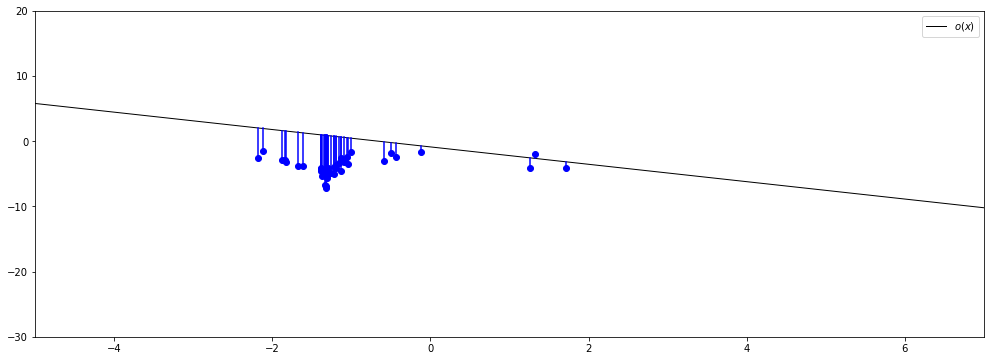

In [15]:
# Set parameters for the distributions

mu_prop = 0.
sigma_prop = 1.

mu_target = -1.33120131
sigma_target = .99985516

xs = np.linspace(-5, 7, 300)

# Create sampling structure
num_samples_pow = 15

uniform_approx_samp_block = i4_sobol_generate(1, np.power(2, num_samples_pow), skip=10)
#normal_approx_samp_block = norm.ppf(uniform_approx_samp_block)

normal_approx_samp_block = np.random.normal(size=(2**num_samples_pow, 1))

normal_tree = IntervalTree()

for i in range(2**num_samples_pow):
    normal_tree.add(normal_approx_samp_block[i, 0])

log_diff = lambda x: normal_normal_log_diff(x, mu_prop, sigma_prop, mu_target, sigma_target)

plt.figure(figsize=(17, 6))
plt.plot(xs, log_diff(xs), color='k', label="$o(x)$", linewidth=1)

res = a_star_sample_(prop_samp=lambda: norm.ppf(np.random.uniform()), 
                     prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                     log_diff=log_diff, 
                     region_bound=lambda a, b: normal_normal_region_bound(a, 
                                                                         b, 
                                                                         mu_prop, 
                                                                         sigma_prop, 
                                                                         mu_target, 
                                                                         sigma_target),
                     samp_tree=normal_tree,
                     samp_list=None,#normal_approx_samp_block[:, 0],
                     seed=None,
                     eps=1e-2,
                     verbose=True)

plt.legend()
plt.ylim([-30, 20])
plt.xlim([-5, 7])

lb, sample, idx = res

print(res)

In [ ]:
# for reproducibility
np.random.seed(4)

samples = []
sample_indices = []
num_samples = 300

for i in tqdm(range(num_samples)):
    _, samp, samp_idx = a_star_sample_(prop_samp=lambda: norm.ppf(np.random.uniform()), 
                                         prop_log_mass=lambda a, b: np.log(norm.cdf(b) - norm.cdf(a)), 
                                         log_diff=log_diff, 
                                         region_bound=lambda a, b: normal_normal_region_bound(a, 
                                                                                             b, 
                                                                                             mu_prop, 
                                                                                             sigma_prop, 
                                                                                             mu_target, 
                                                                                             sigma_target),
                                         samp_tree=normal_tree,
                                         samp_list=None,#normal_approx_samp_block[:, 0],
                                         seed=None,
                                        verbose=False)
    
    samples.append(samp)
    sample_indices.append(samp_idx)
    
samples = np.array(samples)

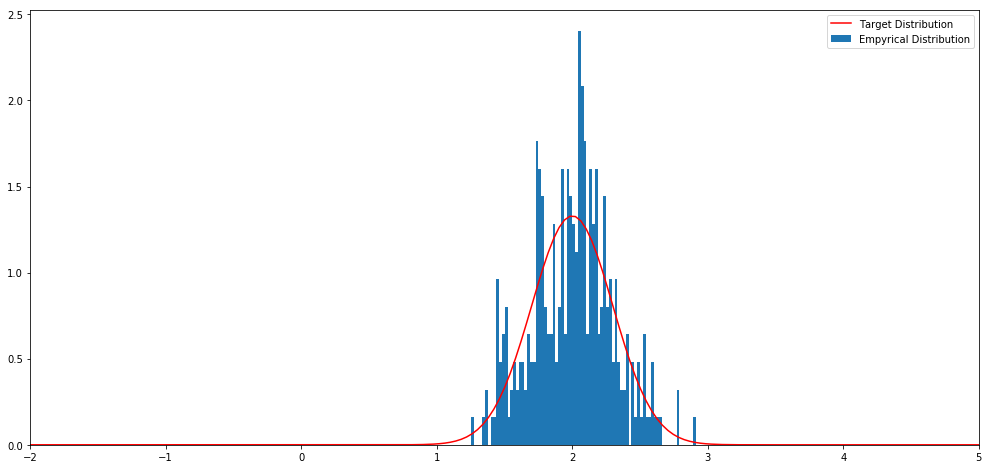

In [19]:
plt.figure(figsize=(17, 8))
plt.hist(samples, bins=80, density=True, label="Empyrical Distribution")
plt.plot(xs, norm.pdf(xs, mu_target, sigma_target), color='r', label="Target Distribution")

plt.xlim([mu_target - 4, mu_target + 3])
plt.legend()
plt.show()

In [31]:
bt = IntervalTree()
bt.add(1)
bt.add(5)
bt.add(3)
bt.add(12)
bt.add(-5)
bt.add(-3)
bt.add(-12)

bt.pretty_print()

bt.between(-np.inf, np.inf)

         -12 : 6
     -5 : 4
         -3 : 5
 1 : 0
         3 : 2
     5 : 1
         12 : 3


(1, 0)

In [57]:
normal_approx_samp_block[:, 0]

array([ 0.00000000e+00,  6.74489750e-01, -6.74489750e-01, ...,
        7.64962243e-05, -4.00877259e+00, -3.91195299e+00])

In [58]:
help(i4_sobol_generate)

Help on function i4_sobol_generate in module sobol_seq.sobol_seq:

i4_sobol_generate(dim_num, n, skip=1)
    i4_sobol_generate generates a Sobol dataset.
    
    Parameters:
      Input, integer dim_num, the spatial dimension.
      Input, integer N, the number of points to generate.
      Input, integer SKIP, the number of initial points to skip.
    
      Output, real R(M,N), the points.



In [70]:
len(normal_approx_samp_block[:, 0])

32768

In [71]:
normal_approx_samp_block[:, 0][0]

-0.9959469622565148